# Ungraded Lab: Multi-class Classifier

In this lab, you will look at how to build a model to distinguish between more than two classes. The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters. Let's dive in!



## Imports

In [11]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

## Inspect the Dataset

You will be using the [Rock-Paper-Scissors dataset](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors), a gallery of hands images in Rock, Paper, and Scissors poses.

As usual, you will assign the directory names into variables and look at the filenames as a sanity check.

In [12]:
BASE_DIR = './rps'

rock_dir = os.path.join(BASE_DIR, 'rock')
paper_dir = os.path.join(BASE_DIR, 'paper')
scissors_dir = os.path.join(BASE_DIR, 'scissors')

print(f'total training rock images: {len(os.listdir(rock_dir))}')
print(f'total training paper images: {len(os.listdir(paper_dir))}')
print(f'total training scissors images: {len(os.listdir(scissors_dir))}')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

print()
print(f"5 files in the rock subdir: {rock_files[:5]}")
print(f"5 files in the paper subdir: {paper_files[:5]}")
print(f"5 files in the scissors subdir: {scissors_files[:5]}")

total training rock images: 840
total training paper images: 841
total training scissors images: 840

5 files in the rock subdir: ['rock05ck01-058.png', 'rock06ck02-092.png', 'rock04-076.png', 'rock02-078.png', 'rock01-079.png']
5 files in the paper subdir: ['paper02-024.png', 'paper06-101.png', 'paper01-061.png', 'paper02-105.png', 'paper06-020.png']
5 files in the scissors subdir: ['scissors02-050.png', 'testscissors01-042.png', 'testscissors02-005.png', 'scissors03-013.png', 'scissors01-015.png']


You can also inspect some of the images to see the variety in your model inputs.

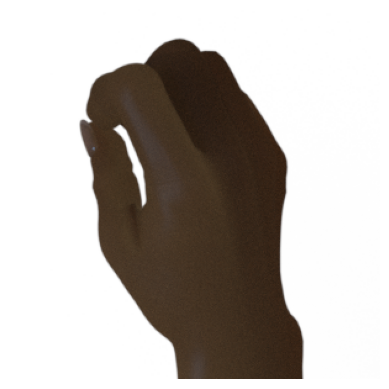

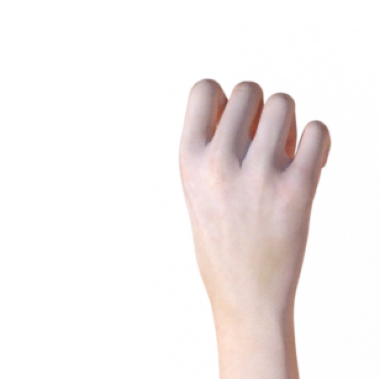

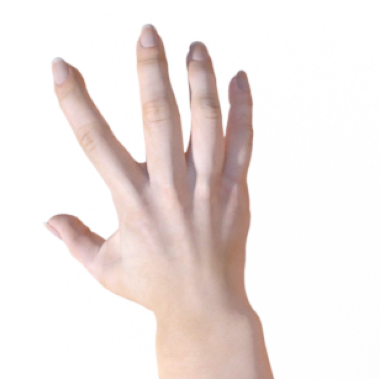

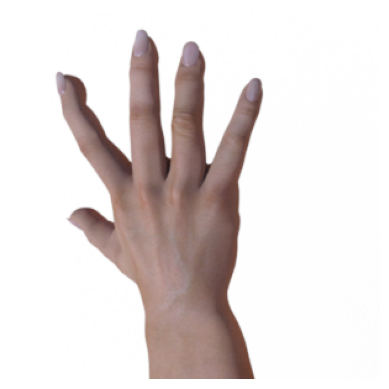

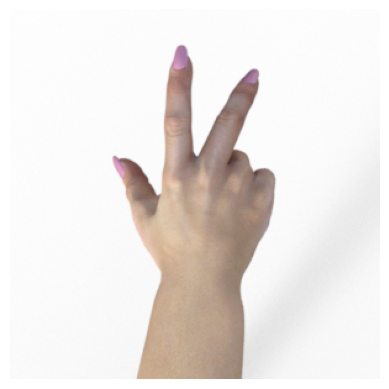

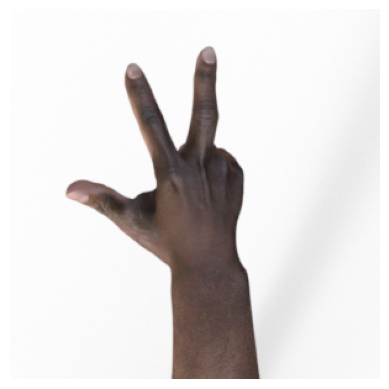

In [13]:
next_rock = [os.path.join(rock_dir, fname)
             for fname in random.sample(rock_files, k=2)]
next_paper = [os.path.join(paper_dir, fname)
              for fname in random.sample(paper_files, k=2)]
next_scissors = [os.path.join(scissors_dir, fname)
                 for fname in random.sample(scissors_files, k=2)]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

## Build the model

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some `Dense` layers for the classification. The output layer would be a 3-neuron `Dense` layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be paper-rock-scissors (e.g. a `[0.8 0.2 0.0]` output means the model is predicting 80% probability for paper and 20% probability for rock.

You can examine the architecture with `model.summary()` below.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
    tf.keras.layers.Rescaling(1./255),
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,473,475 (13.25 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

## Preprocess the Image Data

You will prepare the training and validation datasets as before. The label mode will be `categorical` because you will predict more than two classes.

In [15]:
TRAINING_DIR = "./rps"
VALIDATION_DIR = "./rps-test-set"

# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
    )

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical'
    )

# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Found 2521 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


## Prepare the Model for Training

You will use data augmentation to generate other poses that the model needs to learn.

In [16]:
# Create a model with data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
    ])

# Attach the data augmentation model to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model
])

You will compile the model using a [`categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function to quantify the error across all 3 classes.

In [17]:
# Set the training parameters
model_with_aug.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the model and evaluate the results

You will train for 25 epochs and evaludate the results afterwards. Observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to the training set.



In [18]:
# Train the model
history = model_with_aug.fit(
    train_dataset_final,
    epochs=25,
    validation_data = validation_dataset_final,
    verbose = 1
)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3400 - loss: 1.3310 - val_accuracy: 0.5591 - val_loss: 1.0959
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3597 - loss: 1.1003 - val_accuracy: 0.4355 - val_loss: 1.0575
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3935 - loss: 1.0808 - val_accuracy: 0.7419 - val_loss: 0.8693
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4575 - loss: 1.0194 - val_accuracy: 0.8038 - val_loss: 0.7148
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5711 - loss: 0.8945 - val_accuracy: 0.7903 - val_loss: 0.4856
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6443 - loss: 0.7747 - val_accuracy: 0.7204 - val_loss: 0.6423
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7006 - loss: 0.6762 - val_accuracy: 0.8790 - val_loss: 0.2994
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7580 - loss: 0.5699 - val_accuracy: 0.9086 - v

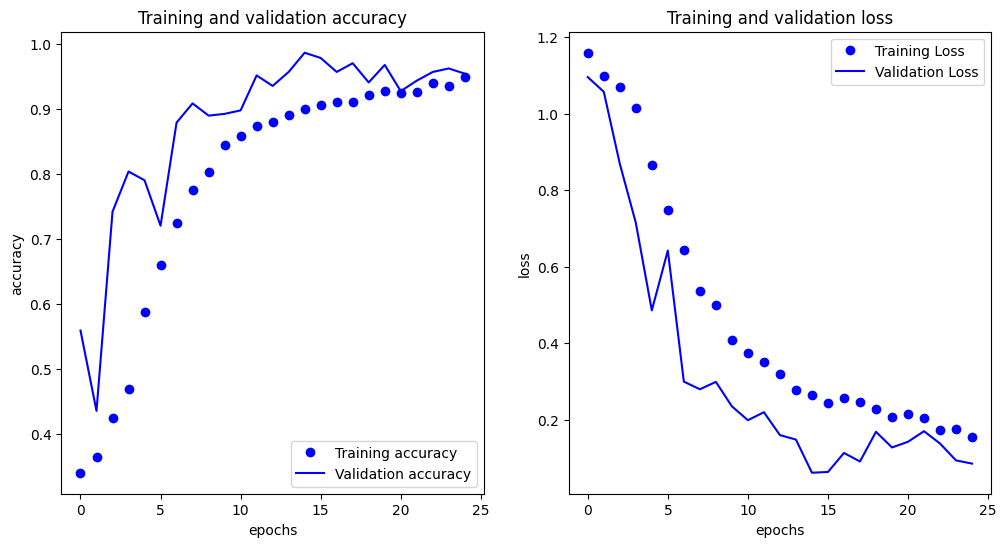

In [19]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

# Model Prediction

You can feed in a picture and have the model classify it as rock, paper, or scissors. You can upload your own images or use the ones available [here](https://storage.googleapis.com/tensorflow-1-public/course2/week4/rps-validation.zip).

In [20]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["paper", "rock", "scissors"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

## Wrap Up

That concludes this short exercise on the multi-class classifiers. You saw that with just a few changes, you were able to convert your binary classifiers to predict more classes. You used the same techniques for data and model preparation and were able to get relatively good results in just 25 epochs. For practice, you can search for other datasets (e.g. [here](https://archive.ics.uci.edu/datasets)) with more classes and revise the model to accomodate it. Try to experiment with different layers and data augmentation techniques to improve your metrics.